# レイヤの実装と練習
## おしながき
- 乗算レイヤ
- 加算レイヤ
- sigmoidレイヤ
- Affineレイヤ
- Softmax-with-lossレイヤ
- 誤差逆伝搬法

In [1]:
#最初のお約束の設定
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
#import common.gradient as g #例えば、本書の共通ライブラリを読み込む場合の設定
import numpy as np
import matplotlib.pylab as plt
######################################################

## 乗算レイヤの写経

In [2]:
#乗算レイヤ
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, z):
        return z * self.y, z * self.x

## りんご２個の買い物の計算グラフ〜の写経

In [3]:
apple         = 100 #りんごが100円
num_of_apples = 2  #りんごの個数
tax           = 1.1#消費税

apple_layer = MulLayer()
tax_layer   = MulLayer()

apple_layer_result = apple_layer.forward(apple, num_of_apples)
tax_layer_result   = tax_layer.forward(apple_layer_result, tax)

print("===forward 結果===")
print(apple_layer_result)
print(tax_layer_result)

print("=== backward 結果===")
tax_layer_back = tax_layer.backward(1)

print("tax_layerの微分")
print("taxの微分")
upper, lower = tax_layer_back
print(lower)

print("apple_layerの微分")
upper, lower = apple_layer.backward(upper)

print("appleの微分")
print(upper)
print("num_of_appleの微分")
print(lower)

===forward 結果===
200
220.00000000000003
=== backward 結果===
tax_layerの微分
taxの微分
200
apple_layerの微分
appleの微分
2.2
num_of_appleの微分
110.00000000000001


## 加算レイヤの実装の写経

In [4]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        return x + y
    
    def backward(self, z):
        return z, z

## 複雑な例（りんご２個と、みかん３個の買い物）の計算グラフ〜の写経

In [5]:
apple         = 100 #りんごの値段
num_of_apples = 2   #りんごの個数

orange        = 150 #みかんの値段
num_of_oranges= 3   #みかんの個数

tax           = 1.1 #消費税率

apple_layer            = MulLayer()
orange_layer           = MulLayer()
apple_and_orange_layer = AddLayer()
tax_layer              = MulLayer()

print("==== forward ====")
apple_layer_res            = apple_layer.forward(apple, num_of_apples)
orange_layer_res           = orange_layer.forward(orange, num_of_oranges)
apple_and_orange_layer_res = apple_and_orange_layer.forward(apple_layer_res, orange_layer_res)
forward_res                = tax_layer.forward(apple_and_orange_layer_res, tax)

print(forward_res)

print("==== backward ====")
upper, lower = tax_layer.backward(1)
print("== taxの微分 ==")
print(lower)

print("== りんご、りんごの個数、みかん、みかんの個数の微分 == ")
dx_apple, dx_orange = apple_and_orange_layer.backward(upper)
upper, lower = apple_layer.backward(dx_apple)
print("== りんごの微分==")
print(upper)
print("== りんごの個数の微分")
print(lower)

upper, lower = orange_layer.backward(dx_orange)
print("== みかんの微分==")
print(upper)
print("== みかんの個数の微分")
print(lower)

==== forward ====
715.0000000000001
==== backward ====
== taxの微分 ==
650
== りんご、りんごの個数、みかん、みかんの個数の微分 == 
== りんごの微分==
2.2
== りんごの個数の微分
110.00000000000001
== みかんの微分==
3.3000000000000003
== みかんの個数の微分
165.0


## ★ReLUレイヤの実装の写経
### その前に、ReLU関数とはなにか

$$
    ReLU(x) =
        \begin{cases}
            x \quad x > 0 \\
            0 \quad x \leqq 0 \\
        \end{cases}
$$

その微分は以下。

$$
    ReLU(x)' =
        \begin{cases}
            1 \quad x > 0 \\
            0 \quad x \leqq 0 \\
        \end{cases}
$$

## ReLUレイヤの実装

### 間違った実装から
#### なぜ勘違いしたのか？
入力が関数の形を見て、スカラー的に判断してしまった。
入力がベクトルの時、ベクトルのそれぞれの要素に対して演算を行う必要がある。
以下の実装は、入力がスカラーの場合は良いが、ベクトルの場合に対応していない。

In [6]:
class ReluBad:
    def __init__(self):
        self.x = None
        pass
    
    def forward(self, x):
        self.x = x
        if x > 0:
            return x
        else:
            return 0
        
    def backward(self):
        if self.x > 0:
            return 1
        else:
            return 0

### 正しい実装

### numpyの機能をあまり使わない素朴な実装(さらなる間違いも発覚、根本的な理解不足）
配列操作周りは改善したが、そもそもの根本的な理解不足があり。

In [7]:
class ReluNaive:
    def __init__(self):
        #forward時に正の要素は通し、負のものは通さない。backward時も同様に正は通して、負は通さない。
        #この時、forward時に通したもの（インデックス）を覚えておく必要があるので、そもそも、クラスのインスタンス変数として
        #記憶しておくものは、xではなく、maskである。
        self.x = None
        pass
    
    def forward(self, x):
        self.x = x
        y = x.copy()
        for idx in range(y.shape[0]):
            if y[idx] <= 0:
                y[idx] = 0
        return y
        
    def backward(self): #ここも間違い。逆伝搬してきた値に、自分自身の微分を掛けたものを復帰値とする必要がある。
                        #このため、まず、引数を１つ受け取る必要があるが、設定されていない間違い
        y = x.copy()
        for idx in range(y.shape[0]):
            if y[idx] > 0:
                y[idx] = 1 #正のものは、逆伝搬してきた値に1を掛けるのが正しい実装。
            else:
                y[idx] = 0 #ゼロ以下のものを０にするだけ。
        return y

### numpyの機能を使った実装および、Reluへの正しい理解での実装
テキストの実装の通り、numpyを使うとこの辺の実装が大変スマートになる。
ブロードキャストとマスク機能を使う。

機械学習のプログラミングではベクトルや行列が頻出であり、この辺をしっかり抑えることが肝要。

#### ブロードキャストを使った比較と、マスク機能の練習

In [8]:
x = np.array([[1.0, -0.5],[-2.0, 3.0]])
y = x.copy()

print(x)
print(y)

mask = (x <= 0) #ブロードキャスト機能により、配列の各要素を比較した結果の配列を作ることができる
print(mask)

y[mask] = 0 # mask機能を使うと、Trueとなるindexの要素に値（この場合は０）を代入できる
print(y)

#y[[True]] = 0 # Error
#print(y)      # Error

print(range(y.shape[0]))

[[ 1.  -0.5]
 [-2.   3. ]]
[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]
[[1. 0.]
 [0. 3.]]
range(0, 2)


### numpyの機能を使った効率的な実装(テキストの写経)　〜　完成版
以下、修正点
- インプットをベクトルを意識したものにした
- numpyのマスク機能を使って効率的に
- Relu関数の微分（forwardで通したものを記憶して、backwardに反映)をした。つまり、インスタンス変数としてmaskを記憶するようにした

In [9]:
class ReluMy:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        y = x.copy()
        mask = (x <= 0)
        y[mask] = 0
        self.mask = mask
        return y
        
    def backward(self, dout):
        dout[self.mask] = 0
        return dout

# ★sigmoidレイヤの実装（テキストの写経)
## まずは数式から（テキストP145)

計算グラフを自力で書いて求めるのは別途練習するとして、ここでは実装に重きを置くため、テキストをさっと読んで、結論だけを利用する。
つまり、テキストＰ１４５を見ると、sigmoidレイヤのforwardとbackward（微分)は以下。

まず、forward方向（すでにsigmoid関数として実装していることを思い出そう）。
以下、yとxはベクトルであることに注意する。数式としてはやや正確ではないと思うが、numpyのブロードキャストを想像しながら数式を見るとわかりやすい。詳しくは実装にて。
$$
    y = \frac{1}{1+exp^(-x)} \\
$$

以下、backward方向

$$
      y' = \frac{\partial L}{\partial y} y^2 exp(-x) \\
$$

なお、以下は、sigmoidレイヤに最初に逆伝搬で入ってきた、隣のレイヤからの値である。yはsigmoidレイヤで出力した値であり、実装ではインスタンスに保持しておくべき値であろうことに注意しておこう。xも同様に記録しておく必要あり。

### 自力で実装してみる。

In [10]:
class SigmoidMy:
    def __init__(self):
        self.x = None
        self.y = None
        pass
    
    #入力xはnumpyのベクトルであることに注意。
    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        self.x = x
        self.y = y
        return y
    
    def backward(self, dout):
        return dout * (self.y*self.y) * np.exp(-self.x)

テキストではＰ１４６で導出される式から、出力yのみで効率よく実装されているが、自力版はそうしていない。
テキスト版と自力版のsigmoidレイヤでテストデータを試してみよう。

In [11]:
from common.layers import Sigmoid

t = Sigmoid()
m = SigmoidMy()

X = np.arange(-5.0, 5.0, 1)
print(X)

t1 = t.forward(X)
print(t1)

m1 = m.forward(X)
print(m1)

t2 = t.backward(1)
print(t2)

m2 = m.backward(1)
print(m2)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.]
[0.00669285 0.01798621 0.04742587 0.11920292 0.26894142 0.5
 0.73105858 0.88079708 0.95257413 0.98201379]
[0.00669285 0.01798621 0.04742587 0.11920292 0.26894142 0.5
 0.73105858 0.88079708 0.95257413 0.98201379]
[0.00664806 0.01766271 0.04517666 0.10499359 0.19661193 0.25
 0.19661193 0.10499359 0.04517666 0.01766271]
[0.00664806 0.01766271 0.04517666 0.10499359 0.19661193 0.25
 0.19661193 0.10499359 0.04517666 0.01766271]


自力版とテキスト版の出力はあっていそうなので、自力版の実装も正しいと思う。

# ★Affineレイヤの実装（テキストの写経)
## まずは数式から

forward方向。行列Yは次のレイヤへの出力。行列Xは入力、行列Wは重み。ベクトルbはバイアス。

$$
    \boldsymbol{Y} =  \boldsymbol{X}\boldsymbol{W} + \boldsymbol{b}
$$

ここで、バイアスの加算については、注意が必要で、XWのそれぞれの行に対して、bが加算されていくことに注意（バイアスの微分で再び登場するので頭の片隅に入れておく）

backward方向。行列Xの微分と行列Wの微分の２つがある。なお、行列Lはネットワークから出力された値で、一番最初に逆伝搬する値（このAffineレイヤに逆伝搬してくる値ではないことに注意。テキストＰ１３３を参照）。

$$
    \frac{\partial L}{\partial \boldsymbol{X}} = \frac{\partial L}{\partial \boldsymbol{Y}} \boldsymbol{W}^T  \\
$$

なお、以下は、Affineレイヤに最初に逆伝搬で入ってくる値であることに注意。

$$
    \frac{\partial L}{\partial \boldsymbol{Y}}\\
$$

行列Wの微分は以下。


$$
    \frac{\partial L}{\partial \boldsymbol{W}} = \boldsymbol{X}^T \frac{\partial L}{\partial \boldsymbol{Y}}   \\
$$

次に、バイアスの微分を考える必要がある。
forwardでのバイアスの加算は、それぞれのデータ（１行目のデータ、２行目のデータ・・・）に対して加算が行われる。このため、バイアスの微分では、逆伝搬の値がバイアスの要素に集約される必要がある。つまり、Affineレイヤに最初に逆伝搬してきた値であるdY(複数行、複数列）を列の要素毎に合計したものを要素にもつベクトルがバイアスの微分になる。

これが、Affineレイヤのforwardとbackwardのすべてである。以下、この数式を頼りにまずは、自力で実装してみる。


### 自力での実装(→少し誤っている)

In [12]:
class AffineMy1:
    def __init__(self, X, W, b):
        self.X = X
        self.W = W
        self.b = b
        pass
    
    def forward(self):
        return np.dot(self.X,self.W) + self.b
    
    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        dW = np.dot(self.X.T, dout)
        db = np.sum(dout, axis=0) #列要素毎にsumしたベクトルを作る
        
        return dX, dW, db

テキストの正解とは異なる部分がおおい。
ただし、あまり本質的な誤りではなく、おそらく、AffineLayerMyをAffineLayerとしてプログラミングしやすくする際の差分だと思う。
- AffineLayerMyではコンストラクタの引数にXがあるが、テキストのAffineでは無い
- AffineLayerMyではforwardにXは無いが、テキストのAffineにはある。
- backwardではdXのみ返却して、dWやdbはインスタンス変数に保持したまま

つまり、入力値Ｘについては、コンストラクタで覚えるのではなく、forwardで都度覚えるという形のほうが良いということだろう。
考えてみれば、コンストラクタ時にはまだ、入力Ｘは決まっていない気がする。
backwardでdXのみ返却するのも、プログラミングのしやすさを重視したものだと想像する（テキストを読み進めるなかで、この予想が正しいかを検証する）

### テキストでの実装（そのまま、上記写経に合わせる）

In [13]:
class AffineMy:
    def __init__(self, W, b):
        self.W  = W
        self.b  = b
        self.X  = None
        self.dW = None
        self.db = None
    
    def forward(self,X):
        #forwardのつど、Xを記憶
        self.X = X
        return np.dot(self.X,self.W) + self.b
    
    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        #dW, dbはインスタンス変数に覚えるのみ。
        self.dW = np.dot(self.X.T, dout) 
        self.db = np.sum(dout, axis=0) #列要素毎にsumしたベクトルを作る
        
        return dX #dXのみ返却するようにした。

# ★ softmax-with-lossレイヤの実装
## 数式から

計算グラフからの導出はテキストに詳しい。詳細はまだ理解していないが、実装を優先したいため、Ｐ１５４の図５−３０を参照する。
これによれば、softmax-with-lossレイヤのforward方向はsoftmax関数を通したもの、backward方向は、forward方向で得たベクトルの要素から対応する教師データのラベルに対応する値を引けば良い。詳しくは前述の図を参照。

## 自力で実装してみる（誤り=テキストと異なる点が幾つか存在）。

In [14]:
from common.functions import cross_entropy_error, softmax

class SoftmaxWithLossMy1:
    def __init__(self):
        self.y = None
        self.t = None
        pass
    
    #x: 入力データ（ベクトル）
    #t: 教師データ(ベクトル/one hot表現)
    #出力：softmaxされたニューラルネットワークの推論結果
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        res = cross_entropy_error(self.y , t)
        return res
    
    def backward(self):
        return self.y - self.t #ブロードキャストを利用

テキストと異なる点は以下。
- cross_entropy_errorの結果がインスタンス変数に記録されていない。ただし、これは記録されていなくてもloss自体はbackwardの計算にあらわれてこないため。lossを記録するのは単にプログラミングの利便性を上げるためのものだと想像。
- backwardでbatch_sizeで割った値を復帰していない。これは盲点だった。ミニバッチへの考慮が必要。tの行数(ミニバッチに含まれる画像などの枚数（ピクセル数ではない数）でself.y - self.tの各要素を割ることで、データあたり（例：画像あたり）の誤差を逆伝搬するというもの

### ミニバッチ対応版

In [15]:
class SoftmaxWithLossMy:
    def __init__(self):
        self.y = None
        self.t = None
        self.loss = None #softmaxの出力結果
        pass
    
    #x: 入力データ（ベクトル）
    #t: 教師データ(ベクトル/one hot表現)
    #出力：softmaxされたニューラルネットワークの推論結果
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y , t)
        return self.loss
    
    def backward(self, dout=1): #backward関数群のインタフェースの整合性のため、ダミーでdoutを追加している。
        batch_size = self.t.shape[0]
        return (self.y - self.t) / batch_size #ブロードキャストを利用

# ★誤差逆伝搬法の実装
## 概要から

テキストのＰ１５７に記載があるように、ニューラルネットワークの手順は以下。詳細はテキストを参照。

- ステップ1(ミニバッチ)
- ステップ2(勾配の算出)
- ステップ3(パラメータの更新)
- ステップ4(繰り返す)

そこで、TwoLayerNetMyを更新する。

## TwoLayerNetMy2
誤差逆伝搬法に対応したTwoLayerNetMy2を作る。差分は最初にレイヤを作る、init_layersメソッド、および、forward_layers_for_predictionメソッド、
誤差逆伝搬法そのものである、gradientメソッドの追加である。

In [16]:
from collections import OrderedDict

class TwoLayerNetMy:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        ## 【W1層】
        ## インプットは、(１行、インプット列)の行列。それに対して、W1層は、
        ## （インプット行、hidden_size列）の行列で、インプットの列数と同じ行数で受ける必要がある。
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        
        ## 【W2層】
        ## W1層の出力が（インプット行、hidden_size列）の行列になる。これがそのまま、W2層へのインプットとなる。
        ## それに対して、アウトプットを(１行、output_size列)の行列に変換する必要があるから、自ずと、W2は、
        ## (hidden_size行、output_size列)の行列になる。
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        #レイヤの初期化
        self.init_layers()
        
    #誤差逆伝搬法で対応した新規の関数
    def init_layers(self): #商用実装などではprotected相当にするべきだろう。けど、実験用なのでpublicでよいや
        self.layers = OrderedDict()
        self.layers["Affine1"] = AffineMy(self.params["W1"], self.params["b1"])
        self.layers["Relu1"]   = ReluMy()
        self.layers["Affine2"] = AffineMy(self.params["W2"], self.params["b2"])
        
        self.lastLayer = SoftmaxWithLossMy()

    #誤差逆伝搬法で対応した新規の関数
    def forward_layers_for_prediction(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def predict(self, x):
        return self.forward_layers_for_prediction(x) #誤差逆伝搬法で対応したものに実装を置き換え
        
        #以下の２行はレイヤ構成に対応する前の古いインプリ
        #temp = sigmoid(np.dot(x, self.params['W1']) + self.params['b1'])
        #return  softmax(np.dot(temp, self.params['W2']) + self.params['b2'])
    
    def gradient(self, x, t):
        #forward
        self.loss(x,t)
        
        #backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
    
        grads = {}
        
        grads['W1'] = self.layers["Affine1"].dW
        grads['b1'] = self.layers["Affine1"].db
        grads['W2'] = self.layers["Affine2"].dW
        grads['b2'] = self.layers["Affine2"].db
        
        return grads
        
    #x: 入力データ、 t:教師データ
    def loss(self, x, t):
        return self.lastLayer.forward(self.predict(x), t)
        #以下、誤差逆伝搬法に対応する前の古い実装。
        #return cross_entropy_error(self.predict(x), t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        #最も確率の高い要素のインデックスを取得。ただし、複数行になるため、行毎(axis=1)にＭＡＸなインデックスを得る
        #このため、zの要素数はy.shape[0]になる。
        y1 = np.argmax(y, axis=1)
        t1 = np.argmax(t, axis=1)
        
        accuracy = np.sum( y == t ) #予測のインデックス==教師データの正解インデックスとなる要素をブロードキャストで計算する。
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

## 写経終了。誤差逆伝搬法バージョンを試していく

In [17]:
net = TwoLayerNetMy(input_size = 784, hidden_size = 100, output_size = 10)


#傾きのパラメータサイズの確認
x = np.random.rand(100, 784) # ダミーの入力データ(784ピクセルの画像が100枚分)
t = np.random.rand(100, 10)  # ダミーの正解ラベルが100枚分

grads = net.gradient(x,t)

print("show grads")
print(grads["W1"].shape)
print(grads["b1"].shape)
print(grads["W2"].shape)
print(grads["b2"].shape)
print("===========")

show grads
(784, 100)
(100,)
(100, 10)
(10,)


In [18]:
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet #せっかくなので、テキストのTwoLayerNetを使ってしまおう

#テキストのTwoLayerNetとTwoLayerNetMyを比べてみる

def one_train(network = None):
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

    train_loss_list = []

    #ハイパーパラメータの設定
    iters_num     = 10000
    train_size    = x_train.shape[0] #訓練データの個数(画像の枚数)
    batch_size    = 100
    learning_rate = 0.1

    #network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

    for i in range(iters_num):
        #バッチの状況をiters_numの10%毎に報告する
        #print("batch %d done"%(i) )
        if ((i / iters_num) * 100) % 10 == 0:
            print("batch %d done"%(i) )

        #ミニバッチの取得
        batch_mask = np.random.choice(train_size, batch_size) #0~train_size未満の整数の中からランダムにbatch_size個の整数を生成
        x_batch = x_train[batch_mask] #batch_maskで指定した訓練データを取得する
        t_batch = t_train[batch_mask] #正解ラベルも同様に実施

        #勾配の計算
        #print("calc grad")
        #grad = network.numerical_gradient(x_batch, t_batch)
        #誤差逆伝搬法のほうがずっと高速になるらしい！ →　めちゃくちゃ速い
        grad = network.gradient(x_batch, t_batch)

        #パラメータの更新
        #print("update params")
        for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]

        #学習経過の記録
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
    
    print("done")
    return train_loss_list
        

#試すフェーズ
network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
train_loss_list = one_train(network)


batch 0 done
batch 1000 done
batch 2000 done
batch 3000 done
batch 4000 done
batch 5000 done
batch 6000 done
batch 7000 done
batch 8000 done
batch 9000 done
done


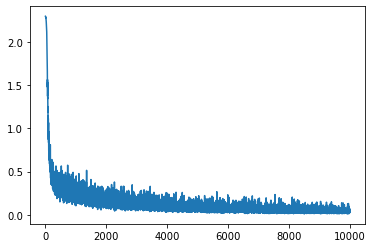

In [19]:
import matplotlib.pylab as plt

x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.show()

すばらしい！学習が進む度にロス率が下がっているコトが確認できた。

batch 0 done
batch 1000 done
batch 2000 done
batch 3000 done
batch 4000 done
batch 5000 done
batch 6000 done
batch 7000 done
batch 8000 done
batch 9000 done
done


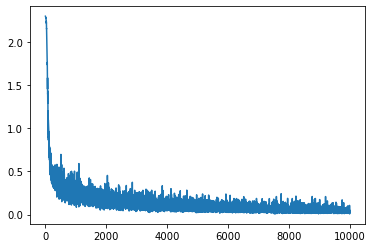

In [20]:
#自分のネットワークを試すフェーズ
network = TwoLayerNetMy(input_size=784, hidden_size=100, output_size=10)
train_loss_list = one_train(network)

x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.show()

自分のネットについても同じ結果となって嬉しい！